---
# Mathematics of Machine and Deep Learning Algorithms 
### Project - Book Review Classification
### M2 D3S 
#### TSE
#### 2021-2022
---
Author : Emir Tarık DAKIN  

In [1]:
# please install first and restart the runtime afterwards
!pip install pyforest
!pip install lazypredict

# 1. Dataset 


## 1.1 Data upload and data features

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
from matplotlib.pyplot import figure

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

import re
import string
import unicodedata

# Others
import time
from pprint import pprint
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
# renamed the file to kindle.csv to avoid confusion
from google.colab import files
files.upload()

Saving kindle.csv to kindle.csv


{'kindle.csv': b',rating,reviewText,summary\n0,5,"This book was the very first bookmobile book I bought when I was in the school book club. I loved the story then and I bet a dollar to a donut I will love it again. If my memory serves, I bought this book in 5th grade. That would have been about 1961. I am looking forward to reliving the memories.",50 + years ago...\n1,1,"When I read the description for this book, I couldn\'t wait to read it. Once I downloaded it to my Kindle, I found it extremely hard to keep reading it.  To be honest, I stopped reading halfway through the book. It began slow and remained a slow, uninteresting read.  It lacked passion; not making love passion, but passion for life. Neither Jada or Aaron were interesting characters and the story was too, too `everything is perfect\'.  Everybody is just so understanding and accommodating--the bit of drama with his father and her grandmother was blah.  To give an example of what I mean (and there are MANY), Aaron finally 

In [9]:
df = pd.read_csv("kindle.csv", encoding = 'latin1')
df['reviewText'] = df['reviewText'].astype(str)
print(df.dtypes)

Unnamed: 0     int64
rating         int64
reviewText    object
summary       object
dtype: object


In [5]:
df.head(5)

Unnamed: 0  ...                          summary
0           0  ...                50 + years ago...
1           1  ...          Boring! Boring! Boring!
2           2  ...  Wiggleliscious/new toy ready/!!
3           3  ...                  Very good read.
4           4  ...                     Great Story!

[5 rows x 4 columns]

In [10]:
# Remove empty review
df_data = df[["reviewText","rating"]].dropna()

# Convert rating as integer
df_data['rating'] = df_data['rating'].astype('int')

In [7]:
# number of tweets by sentiment
class_df = df_data.groupby('rating').count()['reviewText'].reset_index().sort_values(by='rating',ascending=False)
class_df.style.background_gradient(cmap='magma')

In [47]:
print(class_df.to_markdown())

|    |   rating |   reviewText |
|---:|---------:|-------------:|
|  4 |        5 |         3000 |
|  3 |        4 |         3000 |
|  2 |        3 |         2000 |
|  1 |        2 |         2000 |
|  0 |        1 |         2000 |


<IPython.core.display.Javascript object>

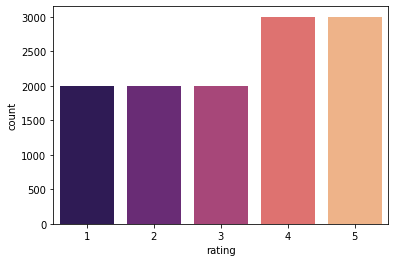

In [5]:
sns.countplot(x="rating", data=df_data, palette='magma')

In [11]:
df_data.loc[df_data['rating'] < 3,'score'] = 1    # negative reviews
df_data.loc[df_data['rating'] == 3,'score'] = 2   # neutral reviews
df_data.loc[df_data['rating'] > 3,'score'] = 3    # positive reviews

# Convert target as integer
df_data['score'] = df_data['score'].astype('int')

df_data.head(5)

reviewText  rating  score
0  This book was the very first bookmobile book I...       5      3
1  When I read the description for this book, I c...       1      1
2  I just had to edit this review. This book is a...       5      3
3  I don't normally buy 'mystery' novels because ...       5      3
4  This isn't the kind of book I normally read, a...       5      3

In [46]:
print(df_data.sample(5).to_markdown())

|       | reviewText                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |   rating |   score |
|------:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<IPython.core.display.Javascript object>

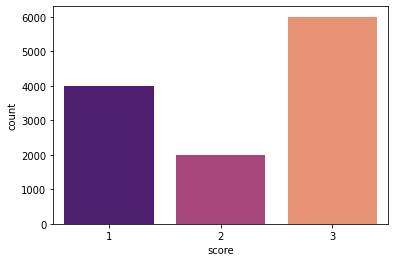

In [11]:
sns.countplot(x="score", data=df_data, palette='magma')

In [12]:
df_data.dtypes

reviewText    object
rating         int64
score          int64
dtype: object

In [13]:
len(df_data)

12000

## 1.2 Data cleaning

### Lowercase and remove punctuations

In [12]:
### Define some functions to lowercase the words and remove some punctuations

def convert_text_to_lowercase(data, colname):
    df = data.copy()
    df[colname] = df[colname].str.lower()
    return df

def not_regex(pattern):
        return r"((?!{}).)".format(pattern)
        
def remove_punctuation(data, colname):
    df = data.copy()
    df[colname] = df[colname].str.replace('\n', ' ')
    df[colname] = df[colname].str.replace('\r', ' ')
    alphanumeric_characters_extended = '(\\b[-/]\\b|[a-zA-Z0-9])'
    df[colname] = df[colname].str.replace(not_regex(alphanumeric_characters_extended), ' ')
    return df
def lower_punctuation(data, colname):
    """
    Takes in a string of text, then performs the following:
    1. convert text to lowercase
    2. remove punctuation and new line characters '\n'
    """
    df = data.copy()
    df = (
        df
        .pipe(convert_text_to_lowercase, colname)
        .pipe(remove_punctuation, colname)
    )
    return df

In [13]:
df_halfway = lower_punctuation(df_data, 'reviewText')

In [14]:
df_halfway['reviewText'].head(5)

0    this book was the very first bookmobile book i...
1    when i read the description for this book  i c...
2    i just had to edit this review  this book is a...
3    i don t normally buy  mystery  novels because ...
4    this isn t the kind of book i normally read  a...
Name: reviewText, dtype: object

In [15]:
df['reviewText'][666]

"The Old Testament has always been a bit of a mystery to me so I've  not studied it as much as other scriptures, until now. This part of David Ridges study series ties it in with gospel principles that are in all the scriptures and we see how the Gospel of Jesus Christ is eternal and was preached and practiced from the beginning."

In [16]:
df_halfway['reviewText'][666]

'the old testament has always been a bit of a mystery to me so i ve  not studied it as much as other scriptures  until now  this part of david ridges study series ties it in with gospel principles that are in all the scriptures and we see how the gospel of jesus christ is eternal and was preached and practiced from the beginning '

In [17]:
tokens_df_halfway                 = [word_tokenize(tweet) for tweet in    df_halfway['reviewText'] ]
df_halfway_tokenized              = df_halfway.copy()
df_halfway_tokenized['reviewText']   = tokens_df_halfway.copy()

### Remove stopwords

In [18]:
def remove_stop_words(data, colname):
    df = data.copy()
    stop_words = stopwords.words('english')
    df[colname] = df[colname].apply(lambda x: [word for word in x if word not in stop_words])
    return df

df_almost = remove_stop_words( df_halfway_tokenized , 'reviewText')

In [19]:
df_almost['reviewText'][666]

['old',
 'testament',
 'always',
 'bit',
 'mystery',
 'studied',
 'much',
 'scriptures',
 'part',
 'david',
 'ridges',
 'study',
 'series',
 'ties',
 'gospel',
 'principles',
 'scriptures',
 'see',
 'gospel',
 'jesus',
 'christ',
 'eternal',
 'preached',
 'practiced',
 'beginning']

### Stem words and untokenize the reviews

In [20]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english") 

stemmed_df    = []

for review in df_almost['reviewText']:
  c = [stemmer.stem(word) for word in review]
  stemmed_df.append(c)

In [21]:
df_almost_stemmed                  = df_almost.copy()
df_almost_stemmed['reviewText']    = stemmed_df.copy()

In [22]:
### untokenizing the reviews

from nltk.tokenize.treebank import TreebankWordDetokenizer
detoken = TreebankWordDetokenizer()

df_cleaned    = df_almost.copy()
df_stemmed    = df_almost_stemmed.copy()

detokens_df_almost           = [detoken.detokenize(review) for review in df_almost['reviewText'] ]
df_cleaned['reviewText']     = detokens_df_almost.copy()

detokens_df_almost_stemmed   = [detoken.detokenize(review) for review in df_almost_stemmed['reviewText'] ]
df_stemmed['reviewText']     = detokens_df_almost_stemmed.copy()

In [23]:
df_cleaned['reviewText'][666]

'old testament always bit mystery studied much scriptures part david ridges study series ties gospel principles scriptures see gospel jesus christ eternal preached practiced beginning'

In [24]:
df_stemmed['reviewText'][666]

'old testament alway bit mysteri studi much scriptur part david ridg studi seri tie gospel principl scriptur see gospel jesus christ etern preach practic begin'

### TF-IDF representation

In [25]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, Model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [26]:
### creating TF-IDF for the cleaned data without stemming

number_of_dimensions = 1500

x_train, x_test, y_train, y_test = train_test_split( df_cleaned['reviewText'], df_cleaned['score'],  test_size=0.20, random_state = 100)

tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 2), ### Using 1-gram and 2-gram words
    max_features=number_of_dimensions,
    max_df=1.0,
    min_df=10)


tfidf_vectorizer.fit(x_train)

x_train_features = tfidf_vectorizer.transform(x_train).toarray()
x_test_features  = tfidf_vectorizer.transform(x_test).toarray()

In [27]:
### creating TF-IDF for the stemmed data
x_train_stemmed, x_test_stemmed, y_train_stemmed, y_test_stemmed = train_test_split( df_stemmed['reviewText'], df_stemmed['score'],  test_size=0.20, random_state = 10)

tfidf_vectorizer2 = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 2), 
    max_features=number_of_dimensions,
    max_df=1.0,
    min_df=10)


tfidf_vectorizer2.fit(x_train_stemmed)

x_train_stemmed_features = tfidf_vectorizer2.transform(x_train_stemmed).toarray()
x_test_stemmed_features  = tfidf_vectorizer2.transform(x_test_stemmed).toarray()

In [28]:
# transforming the target into binary matrix
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
encoder.fit(y_train)
y_train_encoded = encoder.transform(y_train)
y_train_stemmed_encoded = encoder.transform(y_train_stemmed)

# 2. ML algorithms

## 2.1 Lazy classifier

In [30]:
import pyforest
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [31]:
encoder1 = LabelEncoder()

fit_train = encoder1.fit(y_train)
fit_test = encoder1.fit(y_test)

### encoded the sentiments into different categories

labeled_y_train = encoder1.transform(y_train)
labeled_y_test = encoder1.transform(y_test)


fit_train_stemmed = encoder1.fit(y_train_stemmed)
fit_test_stemmed = encoder1.fit(y_test_stemmed)

### encoded the sentiments into different categories

labeled_y_train_stemmed = encoder1.transform(y_train_stemmed)
labeled_y_test_stemmed = encoder1.transform(y_test_stemmed)

In [29]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

In [48]:
clf = LazyClassifier(verbose=0,ignore_warnings=True)
models, predictions = clf.fit(x_train_features, x_test_features, labeled_y_train, labeled_y_test)

100%|██████████| 29/29 [25:18<00:00, 52.36s/it]


In [73]:
print(models.to_markdown())

| Model                         |   Accuracy |   Balanced Accuracy | ROC AUC   |   F1 Score |   Time Taken |
|:------------------------------|-----------:|--------------------:|:----------|-----------:|-------------:|
| NearestCentroid               |   0.695    |            0.662475 |           |   0.712826 |     0.711752 |
| LinearDiscriminantAnalysis    |   0.7175   |            0.629369 |           |   0.71278  |     8.89857  |
| RidgeClassifierCV             |   0.734167 |            0.619075 |           |   0.712769 |     8.29491  |
| RidgeClassifier               |   0.73375  |            0.618671 |           |   0.712429 |     1.61702  |
| LogisticRegression            |   0.690417 |            0.614999 |           |   0.691442 |     7.19013  |
| LinearSVC                     |   0.6975   |            0.614471 |           |   0.693572 |   103.08     |
| LGBMClassifier                |   0.732917 |            0.612181 |           |   0.708803 |    37.4257   |
| BernoulliNB      

In [43]:
clf_stemmed = LazyClassifier(verbose=0,ignore_warnings=True)
models_stemmed, predictions_stemmed = clf_stemmed.fit(x_train_stemmed_features, x_test_stemmed_features, labeled_y_train_stemmed, labeled_y_test_stemmed)

100%|██████████| 29/29 [19:35<00:00, 40.53s/it]


Accuracy  ...  Time Taken
Model                                    ...            
NearestCentroid                    0.69  ...        0.66
BernoulliNB                        0.70  ...        0.80
LGBMClassifier                     0.72  ...       39.28
LinearDiscriminantAnalysis         0.69  ...        8.65
RidgeClassifierCV                  0.71  ...        8.11
RidgeClassifier                    0.71  ...        1.60
SVC                                0.73  ...      288.48
XGBClassifier                      0.71  ...      143.08
LogisticRegression                 0.67  ...        7.31
SGDClassifier                      0.67  ...       18.70
ExtraTreesClassifier               0.72  ...       21.16
PassiveAggressiveClassifier        0.66  ...        2.81
Perceptron                         0.66  ...        1.49
LinearSVC                          0.66  ...      100.35
GaussianNB                         0.61  ...        0.84
CalibratedClassifierCV             0.70  ...      351.73
RandomForestClassifier             0.70  ...       10.03
AdaBoostClassifier                 0.67  ...       17.02
BaggingClassifier                  0.65  ...       32.15
QuadraticDiscriminantAnalysis      0.68  ...       11.64
DecisionTreeClassifier             0.57  ...        6.17
ExtraTreeClassifier                0.55  ...        0.85
KNeighborsClassifier               0.51  ...       79.94
LabelSpreading                     0.33  ...       10.50
LabelPropagation                   0.33  ...        9.33
DummyClassifier                    0.39  ...        0.59

[26 rows x 5 columns]

In [45]:
print(models_stemmed.to_markdown())

| Model                         |   Accuracy |   Balanced Accuracy | ROC AUC   |   F1 Score |   Time Taken |
|:------------------------------|-----------:|--------------------:|:----------|-----------:|-------------:|
| NearestCentroid               |   0.68875  |            0.647887 |           |   0.704496 |     0.664193 |
| BernoulliNB                   |   0.701667 |            0.620169 |           |   0.69929  |     0.804801 |
| LGBMClassifier                |   0.722083 |            0.601189 |           |   0.69212  |    39.2781   |
| LinearDiscriminantAnalysis    |   0.6875   |            0.599636 |           |   0.6824   |     8.64746  |
| RidgeClassifierCV             |   0.706667 |            0.591745 |           |   0.682084 |     8.10922  |
| RidgeClassifier               |   0.70625  |            0.590918 |           |   0.681435 |     1.59814  |
| SVC                           |   0.73     |            0.589862 |           |   0.682854 |   288.484    |
| XGBClassifier    

## 2.2 Optimized models

### 2.2.1 Logistic Regression 

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

#### Lasso optimization

In [50]:
# Grid of penalty parameters
param = [{"C": [0.01,0.1,0.25,0.5,0.75,1,2.5,5]}] # dictionary of the values of C used for GridSearchCV

#COMMENT: We use the following codes to get logistic regression + l1 penalty (LASSO case)

logitL = GridSearchCV(LogisticRegression(penalty="l1", solver="liblinear"), param ,cv =5, n_jobs = -1)
logitLasso = logitL.fit(x_train_features, labeled_y_train)
logitLasso.best_params_["C"]

1

In [51]:
# Computation of the loss

print("Best learning rate = %f, Best parameter  = %s" %
      (1.-logitLasso.best_score_ , logitLasso.best_params_))

Best learning rate = 0.270625, Best parameter  = {'C': 1}


In [60]:
# Prediction with the model

yChap = logitLasso.predict(x_test_features)

table = pd.crosstab(yChap, labeled_y_test)
print(table.to_markdown())

# Error on the test set
print("Test accuracy - Logistic regression  Lasso = %f" % (logitLasso.score(x_test_features, labeled_y_test)))

### Comment: 

|   row_0 |   0 |   1 |    2 |
|--------:|----:|----:|-----:|
|       0 | 657 | 133 |   99 |
|       1 |  23 |  63 |   24 |
|       2 | 145 | 181 | 1075 |
Test accuracy - Logistic regression  Lasso = 0.747917


#### Ridge optimization

In [61]:
# Grid of penalty parameters

param=[{"C":[0.01,0.1,0.25,0.5,0.75,1,2.5,5]}]


logitR = GridSearchCV(LogisticRegression(penalty="l2", solver="liblinear"), param, cv = 5, n_jobs = -1)
logitRidge = logitR.fit(x_train_features, labeled_y_train)
logitRidge.best_params_["C"]

0.75

In [62]:
# Error computation  
print("Best score = %f, Best parameter = %s" %
      (1. - logitRidge.best_score_, logitRidge.best_params_))

Best score = 0.269167, Best parameter = {'C': 0.75}


In [64]:
# Prediction 
yChap = logitRidge.predict(x_test_features)

# confusion matrix 
table1 = pd.crosstab(yChap, labeled_y_test)
print(table1.to_markdown())

# Error on the test set
print("Test accuracy - Logistic regression Ridge = = %f" % (logitRidge.score(x_test_features, labeled_y_test)))

### Comment: slightly better than Lasso, in all runs

|   row_0 |   0 |   1 |    2 |
|--------:|----:|----:|-----:|
|       0 | 657 | 120 |   84 |
|       1 |  20 |  58 |   19 |
|       2 | 148 | 199 | 1095 |
Test accuracy - Logistic regression Ridge = = 0.754167


### 2.2.2 Random Forest

In [65]:
from sklearn.ensemble import RandomForestClassifier

In [66]:
# RF with 3 features and 100 trees
rf3 = RandomForestClassifier(n_estimators=100, max_features=3)
rfOpt = rf3.fit(x_train_features, labeled_y_train)

In [67]:
# Prediction on the test set

yChapRF = rfOpt.predict(x_test_features)

# Confusion matrix

tableRF = pd.crosstab(yChapRF, labeled_y_test)
print(tableRF.to_markdown())

# Prediction error on the test set
print("Test accuracy - Random forest = %f" % (rfOpt.score(x_test_features, labeled_y_test)))

### Comment: 65% accuracy when we run this, pretty decent, but not too bad

|   row_0 |   0 |   1 |    2 |
|--------:|----:|----:|-----:|
|       0 | 548 | 111 |   55 |
|       1 |   1 |   1 |    0 |
|       2 | 276 | 265 | 1143 |
Test accuracy - Random forest = 0.705000


### 2.2.3 Support Vector Machine 


In [72]:
##COMMENT: In this section, we would like to perform LinearSVC on the dataset to see if it is better than above case

from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline

## COMMENT: We could not perform parameters tuning for this case since the data set has over 1000 observations so the complexity is 
## O(n_features ** n^2_observations), so we tried many different values of C instead, such as 0.1, 0.5, 1, 1.5, 2, 4, 6 instead, the error rates are around
## 15-18%, not so bad. 

svmlinear = make_pipeline(StandardScaler(), LinearSVC(C=0.001))

svmlinear.fit(x_train_features, labeled_y_train)

# Prediction on the test set

yChapSVM = svmlinear.predict(x_test_features)

# Confusion matrix

tableSVM = pd.crosstab(yChapSVM, labeled_y_test)
print(tableSVM.to_markdown()) 

# Prediction error on the test set
print("Test accuracy - SVC = %f" % (svmlinear.score(x_test_features, labeled_y_test)))

## COMMENT: When we ran this code the accuracy rate is 72.5%, not bad at all

|   row_0 |   0 |   1 |    2 |
|--------:|----:|----:|-----:|
|       0 | 630 | 125 |  103 |
|       1 |  59 |  98 |   74 |
|       2 | 136 | 154 | 1021 |
Test accuracy - SVC = 0.728750


### 2.2.4 Gradient Boosting 

In [61]:
## Simple model with no parameters tuning

import xgboost as xgb

xgb_model = xgb.XGBClassifier(max_depth = 6)
xgb_model.fit(x_train_features, labeled_y_train)

yXG = xgb_model.predict(x_test_features)

tableXG = pd.crosstab(yXG, labeled_y_test)
print(tableXG.to_markdown())

print("Test accuracy Gradient Boosting = %f" % (xgb_model.score(x_test_features, labeled_y_test)))

## COMMENT: Accuracy rate is 71.8%, similar to the Lazy Classifier output

|   row_0 |   0 |   1 |    2 |
|--------:|----:|----:|-----:|
|       0 | 608 | 126 |  107 |
|       1 |  48 |  71 |   46 |
|       2 | 169 | 180 | 1045 |
Test accuracy Gradient Boosting = 0.718333


In [46]:
dm_train = xgb.DMatrix(x_train_features, label=labeled_y_train)
dm_test = xgb.DMatrix(x_test_features, label=labeled_y_test)

# We will set num_boost_rounds to 100, early_stopping_rounds to 10, and objective to binary:logistic.
# All the other values at this stage are default values.
# We will tune our model by chaning the default values.

params = {'max_depth':3, 'min_child_weight':10, 'eta':0.3, 'subsample':1, 
          'colsample_bytree':1,}

# We will use logloss function to evaluate the model's performance
params['eval_metric'] = "logloss"

xgmodel = xgb.train(params, dtrain = dm_train, num_boost_round = 100, evals = [(dm_test,"Test")], 
                    early_stopping_rounds = 10)

print("Best Logloss: {:.3f} | Rounds: {}".format(xgmodel.best_score,xgmodel.best_iteration+1))

[0]	Test-logloss:0.12334
Will train until Test-logloss hasn't improved in 10 rounds.
[1]	Test-logloss:-2.84111
[2]	Test-logloss:-7.03359
[3]	Test-logloss:-7.13145
[4]	Test-logloss:-7.98826
[5]	Test-logloss:-9.36275
[6]	Test-logloss:-9.64677
[7]	Test-logloss:-9.77604
[8]	Test-logloss:-9.92240
[9]	Test-logloss:-10.02660
[10]	Test-logloss:-10.12254
[11]	Test-logloss:-10.36358
[12]	Test-logloss:-10.46984
[13]	Test-logloss:-10.47655
[14]	Test-logloss:-10.60016
[15]	Test-logloss:-10.67820
[16]	Test-logloss:-10.68425
[17]	Test-logloss:-10.87101
[18]	Test-logloss:-10.92101
[19]	Test-logloss:-11.07360
[20]	Test-logloss:-11.00285
[21]	Test-logloss:-11.23006
[22]	Test-logloss:-11.41313
[23]	Test-logloss:-11.51823
[24]	Test-logloss:-11.40009
[25]	Test-logloss:-11.54687
[26]	Test-logloss:-11.66217
[27]	Test-logloss:-11.58802
[28]	Test-logloss:-11.69787
[29]	Test-logloss:-11.76440
[30]	Test-logloss:-11.86220
[31]	Test-logloss:-11.94295
[32]	Test-logloss:-12.14137
[33]	Test-logloss:-12.13824
[34]	Tes

In [62]:
# after many iterations, the parameters below seem to be best we tried
xgb_model = xgb.XGBClassifier(max_depth=3, n_estimators= 230, eta = 0.3, objective='multi:softprob', num_class = 3,  random_state=41)
xgb_model.fit(x_train_features, labeled_y_train)

yXG = xgb_model.predict(x_test_features)

tableXG = pd.crosstab(yXG, labeled_y_test)
print(tableXG.to_markdown())

print("Test accuracy Gradient Boosting = %f" % (xgb_model.score(x_test_features, labeled_y_test)))

## COMMENT: Accuracy rate is 66%, not so bad for multi classification

|   row_0 |   0 |   1 |    2 |
|--------:|----:|----:|-----:|
|       0 | 622 | 118 |  101 |
|       1 |  45 |  70 |   39 |
|       2 | 158 | 189 | 1058 |
Test accuracy Gradient Boosting = 0.729167


### 2.2.5 Naive Bayes

#### Gaussian Naive Bayes

In [53]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB(priors=[0.33, 0.17, 0.5])
y_pred = gnb.fit(x_train_features, labeled_y_train).predict(x_test_features)

print("Number of mislabeled points out of a total %d points : %d" % (x_test_features.shape[0], (labeled_y_test != y_pred).sum()))

tableGNB = pd.crosstab(y_pred, labeled_y_test)
print(tableGNB.to_markdown())

print("Test accuracy Gaussian Naive Bayes = %f" % (1-((labeled_y_test != y_pred).sum()/x_test_features.shape[0])))

## COMMENT: The computation is very fast due to its simplicity. However, this
## reflects poorly on the accuracy.

Number of mislabeled points out of a total 2400 points : 883
|   row_0 |   0 |   1 |   2 |
|--------:|----:|----:|----:|
|       0 | 580 | 130 | 178 |
|       1 | 152 | 162 | 245 |
|       2 |  93 |  85 | 775 |
Test accuracy Gaussian Naive Bayes = 0.632083


In [34]:
# probabilities calculated for each sentiment. negative - neutral - positive
gnb.class_prior_

array([0.33072917, 0.1690625 , 0.50020833])

In [55]:
nb_classifier = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gs_NB = GridSearchCV(estimator=nb_classifier, 
                 param_grid=params_NB, 
                 cv=5,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy') 
gs_NB.fit(x_train_features, labeled_y_train)

gs_NB.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.3min finished


{'var_smoothing': 1.0}

In [58]:
gnb = GaussianNB(priors=[0.33, 0.17, 0.5], var_smoothing=1)
y_pred = gnb.fit(x_train_features, labeled_y_train).predict(x_test_features)

print("Number of mislabeled points out of a total %d points : %d" % (x_test_features.shape[0], (labeled_y_test != y_pred).sum()))

tableGNB = pd.crosstab(y_pred, labeled_y_test)
print(tableGNB.to_markdown())

print("Test accuracy Gaussian Naive Bayes = %f" % (1-((labeled_y_test != y_pred).sum()/x_test_features.shape[0])))

Number of mislabeled points out of a total 2400 points : 694
|   row_0 |   0 |   1 |   2 |
|--------:|----:|----:|----:|
|       0 | 649 | 131 | 133 |
|       1 |  82 | 146 | 154 |
|       2 |  94 | 100 | 911 |
Test accuracy Gaussian Naive Bayes = 0.710833


#### Categorical Naive Bayes

In [36]:
from sklearn.naive_bayes import CategoricalNB

cnb = CategoricalNB()
y_pred = cnb.fit(x_train_features, labeled_y_train).predict(x_train_features)

print("Number of mislabeled points out of a total %d points : %d" % (x_train_features.shape[0], (labeled_y_train != y_pred).sum()))

tableCNB = pd.crosstab(y_pred,labeled_y_train)
print(tableCNB.to_markdown())

print("Test accuracy Categorical Naive Bayes = %f" % (1-((labeled_y_train != y_pred).sum()/x_train_features.shape[0])))


Number of mislabeled points out of a total 9600 points : 4797
|   row_0 |    0 |    1 |    2 |
|--------:|-----:|-----:|-----:|
|       1 |    0 |    1 |    0 |
|       2 | 3175 | 1622 | 4802 |
Test accuracy Categorical Naive Bayes = 0.500312


# 3. Neural network models

### 3.1 Crude models optimization without regulations

In [32]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

In [33]:
## A function the give Sequential model with many options of regularization.

def build_sequential( opt, first_layer = [256, 'relu'], second_layer = [128, 'relu'],
                     dropout = [0 , 0], l1 = 0 , l2 = 0, batch_normal = False, initializer = None):
  if batch_normal == False: 
    model = Sequential()
    model.add(Dense(first_layer[0] , activation = first_layer[1],
                    kernel_initializer = initializer, # Weights initializer
                    kernel_regularizer = regularizers.l1_l2(l1 = l1, l2 = l2), # l1-l2 regularizer
                    input_shape = (number_of_dimensions, )))
    model.add(Dropout(dropout[0]))
    model.add(Dense(second_layer[0] , activation= second_layer[1]))
    model.add(Dropout(dropout[1]))
    model.add(Dense(3, activation= 'softmax'))
    model.compile(
          loss='categorical_crossentropy',
          optimizer = opt,
          metrics=['accuracy'])
    return model
  # A model with Batch normalization
  elif batch_normal == True: 
    model = Sequential()
    model.add(Dense(first_layer[0] , activation = first_layer[1],
                    kernel_initializer = initializer,
                    kernel_regularizer = regularizers.l1_l2(l1 = l1, l2 = l2),
                    input_shape = (number_of_dimensions, )))
    model.add(Dropout(dropout[0]))
    model.add(BatchNormalization())
    model.add(Dense(second_layer[0] , activation= second_layer[1]))
    model.add(Dropout(dropout[1]))
    model.add(BatchNormalization())
    model.add(Dense(3, activation= 'softmax'))
    model.compile(
          loss='categorical_crossentropy',
          optimizer = opt,
          metrics=['accuracy'])
    return model
  else:
    print("Error: batch_normal should be True or False")



In [34]:
## Define a function to plot the evolution of the loss and the accuracy on the training and the validation test

def plot_history_multiclass(hist):
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5) )
  ax[0].plot(hist.history['loss'], label='train')
  ax[0].plot(hist.history['val_loss'], label='val')
  ax[0].set_title('Loss evolution')
  ax[0].legend()
  ax[1].plot(hist.history['accuracy'], label='train')
  ax[1].plot(hist.history['val_accuracy'], label='val')
  ax[1].set_ylim(0,1)
  ax[1].set_title('Accuracy evolution')
  ax[1].legend()
  plt.show()



In [35]:
## Define a function that performs model fitting and return the evolutions of loss and accuracy

def modelfitting(model, x_train, y_train, epochs, batch_size, verbose, val_split, early = 0):
  if early == 0:
    history = model.fit(x_train, y_train, epochs= epochs, batch_size= batch_size, verbose= verbose, validation_split= val_split)
    plot_history_multiclass(history)
  else: 
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience = early )
    history = model.fit(x_train, y_train, epochs= epochs,
                        batch_size= batch_size, verbose= verbose,
                        validation_split= val_split, callbacks=[early_stopping])
    plot_history_multiclass(history)

## Model evaluation function

def model_evaluation(model, X_test, Y_test):
  encoded_predictions = model.predict(X_test)
# Use the reverse tranformation to transform predicted matrix into vector of integers
  predictions = encoder.inverse_transform(encoded_predictions)
  table = pd.crosstab(predictions, Y_test)
  print("Classification report: \n \n", classification_report(Y_test, predictions))
  print("The confusion matrix is: \n \n", table)

def ConfMatrix(model, X_test, Y_test):
  encoded_predictions = model.predict(X_test)
  predictions = encoder.inverse_transform(encoded_predictions)
  table = pd.crosstab(predictions, Y_test)
  return table

## Function that gives a row of metrics

def model_metrics(model, X_test, Y_test, name = None):
  encoded_predictions = model.predict(X_test)
  y_pred = encoder.inverse_transform(encoded_predictions)
  accuracy  = round(accuracy_score(y_test, y_pred), 4)
  f1        = round(f1_score(y_test, y_pred, average='weighted'), 4)
  precision = round(precision_score(y_test, y_pred, average='weighted'), 4)
  recall    = round(recall_score(y_test, y_pred, average='weighted'), 4)
  roc       = round(roc_auc_score(y_test, encoded_predictions, multi_class='ovr', average='weighted'),4)
  dataframe = pd.DataFrame(np.array([[accuracy, f1, precision, recall ]]),
                   columns=['accuracy', 'f1', 'precision', 'recall' ],
                   index = [name])
  return dataframe


#### Crude model with stochastic gradient descent

Cleaned data

In [57]:
### Raw model without regulation + stochastic gradient descend
crude_model = build_sequential(opt = 'sgd')
crude_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 256)               384256    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 3)                 387       
                                                                 
Total params: 417,539
Trainable params: 417,539
Non-trainable params: 0
_________________________________________________________________


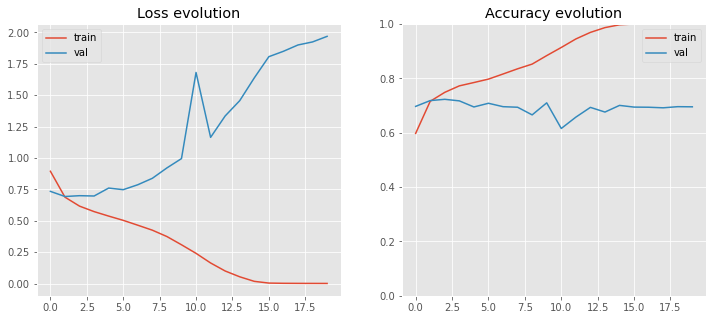

Classification report: 
 
               precision    recall  f1-score   support

           1       0.73      0.74      0.74       825
           2       0.34      0.28      0.31       377
           3       0.78      0.82      0.80      1198

    accuracy                           0.71      2400
   macro avg       0.62      0.61      0.62      2400
weighted avg       0.70      0.71      0.70      2400

The confusion matrix is: 
 
 score    1    2    3
row_0               
1      614  115  108
2       97  107  112
3      114  155  978
           accuracy      f1  precision  recall
Crude SGD    0.7079  0.7018     0.6968  0.7079


In [58]:
modelfitting(crude_model , x_train_features, y_train_encoded,
             epochs = 20, batch_size = 1, verbose = 0, val_split = 0.2)
model_evaluation(crude_model, X_test = x_test_features, Y_test = y_test)
a1 = model_metrics(crude_model, x_test_features , y_test , name = 'Crude SGD')
print(a1)

In [111]:
print(a1.to_markdown())

|           |   accuracy |     f1 |   precision |   recall |
|:----------|-----------:|-------:|------------:|---------:|
| Crude SGD |     0.7133 | 0.7068 |      0.7019 |   0.7133 |


#### Crude model with mini-batch gradient descent + momentum

---




In [36]:
sgd = optimizers.SGD(momentum= 0.2)

Cleaned data

Epoch 1/60
120/120 [==============================] - 2s 9ms/step - loss: 1.0498 - accuracy: 0.4943 - val_loss: 1.0241 - val_accuracy: 0.5000
Epoch 2/60
120/120 [==============================] - 1s 7ms/step - loss: 1.0163 - accuracy: 0.5003 - val_loss: 1.0120 - val_accuracy: 0.5000
Epoch 3/60
120/120 [==============================] - 1s 7ms/step - loss: 1.0097 - accuracy: 0.5003 - val_loss: 1.0088 - val_accuracy: 0.5000
Epoch 4/60
120/120 [==============================] - 1s 7ms/step - loss: 1.0070 - accuracy: 0.5003 - val_loss: 1.0069 - val_accuracy: 0.5000
Epoch 5/60
120/120 [==============================] - 1s 6ms/step - loss: 1.0047 - accuracy: 0.5003 - val_loss: 1.0049 - val_accuracy: 0.5000
Epoch 6/60
120/120 [==============================] - 1s 6ms/step - loss: 1.0025 - accuracy: 0.5003 - val_loss: 1.0029 - val_accuracy: 0.5000
Epoch 7/60
120/120 [==============================] - 1s 6ms/step - loss: 1.0002 - accuracy: 0.5003 - val_loss: 1.0006 - val_accuracy: 0.5000
Epoch 

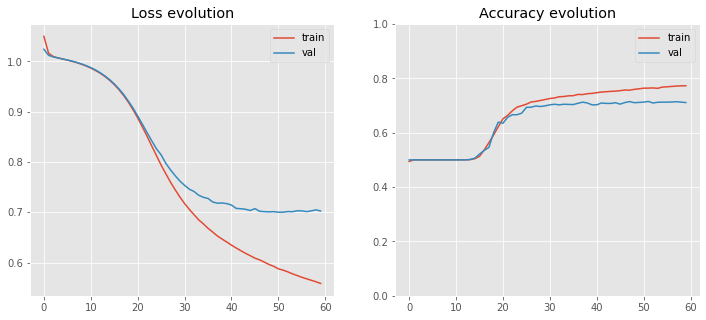

Classification report: 
 
               precision    recall  f1-score   support

           1       0.72      0.83      0.78       825
           2       0.55      0.10      0.16       377
           3       0.78      0.90      0.83      1198

    accuracy                           0.75      2400
   macro avg       0.68      0.61      0.59      2400
weighted avg       0.72      0.75      0.71      2400

The confusion matrix is: 
 
 score    1    2     3
row_0                
1      688  154   108
2       14   36    15
3      123  187  1075
                             accuracy      f1  precision  recall
Crude mini-batch + Momentum    0.7496  0.7076     0.7234  0.7496


In [37]:
crude_model1a = build_sequential(opt = sgd)
modelfitting(crude_model1a , x_train_features, y_train_encoded,
             epochs = 60, batch_size = 64, verbose = 1, val_split = 0.2)
model_evaluation(crude_model1a, X_test = x_test_features, Y_test = y_test)
a2 = model_metrics(crude_model1a, x_test_features , y_test , name = 'Crude mini-batch + Momentum')
print(a2)

In [38]:
print(a2.to_markdown())

|                             |   accuracy |     f1 |   precision |   recall |
|:----------------------------|-----------:|-------:|------------:|---------:|
| Crude mini-batch + Momentum |     0.7496 | 0.7076 |      0.7234 |   0.7496 |


In [59]:
cleaned_list = [a1,a2]
cleaned_dataframe = pd.concat(cleaned_list)

In [60]:
print(cleaned_dataframe.to_markdown())

|                             |   accuracy |     f1 |   precision |   recall |
|:----------------------------|-----------:|-------:|------------:|---------:|
| Crude SGD                   |     0.7079 | 0.7018 |      0.6968 |   0.7079 |
| Crude mini-batch + Momentum |     0.7496 | 0.7076 |      0.7234 |   0.7496 |


### 3.2 CNN models

In [39]:
from gensim.models import FastText
from tensorflow.keras.layers import Activation, Bidirectional, LSTM, Input, Embedding, SpatialDropout1D
from gensim.models import FastText
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [40]:
# The maximum number of words take into account by the model vocabulary
VOCAB_SIZE = 5000
# The maximum number of words per text review
MAX_LENGTH = 100
# Dimension of the embedding layer in the network
EMBEDDING_DIM = 100

In [41]:
# tokenizer: transform sequence of word into sequence of index
tokenizer = Tokenizer(num_words = VOCAB_SIZE, filters='!"#$%&()*+,.:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(x_train)

# vectorize train data and truncate the sentences
data_sequences_train = tokenizer.texts_to_sequences(x_train)
padded_data_sequences_train = pad_sequences(data_sequences_train, maxlen=MAX_LENGTH, padding='post', truncating='post')

# vectorize test data and truncate the sentences
data_sequences_test = tokenizer.texts_to_sequences(x_test) 
padded_data_sequences_test = pad_sequences(data_sequences_test, maxlen=MAX_LENGTH, padding='post', truncating='post')

# Set out-of index vocabulary to 0
padded_data_sequences_train[padded_data_sequences_train >= VOCAB_SIZE] = 0
padded_data_sequences_test[padded_data_sequences_test >= VOCAB_SIZE] = 0 

In [42]:
### Define a function that gives a matrix of weights and number of words to keep

def initialize_embedding_with_fastText(tokenizer, word_vectors, vocab_size, embedding_dim):
    word_index = tokenizer.word_index

    # number of words to keep
    nb_words = min(vocab_size, len(word_vectors.vocab)) + 1

    # initialize the matrix with random numbers
    wv_matrix = (np.random.rand(nb_words, embedding_dim) - 0.5) / 5.0

    # feed the matrix using fastText representation
    for word, i in word_index.items():
        if i >= nb_words:
            continue
        try:
            embedding_vector = word_vectors[word]
            # words not found in embedding index will be all-zeros.
            wv_matrix[i] = embedding_vector
        except:
            pass

    return wv_matrix, nb_words

In [43]:
# Train fastText model
sentences_data = df_cleaned['reviewText'].str.split(' ')

fastText_model = FastText(sentences_data, size=EMBEDDING_DIM,
                          window=5, min_count=3, iter=10,
                          min_n=3, max_n=6, workers=-1)

In [44]:
# Initilaze embedding matrix with fastText vectorization
wv_matrix, input_size = initialize_embedding_with_fastText(tokenizer, fastText_model.wv, VOCAB_SIZE, EMBEDDING_DIM)

In [45]:
len(wv_matrix)

5001

In [46]:
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [47]:
def build_cnn(number_of_classes, vocab_size, max_length,
              embedding_dim, embeddings_initializer = None ,
              dropout = 0, l1 = 0, l2 = 0, trainable = True):
  model = Sequential()
  model.add(Embedding(vocab_size,
                      embedding_dim,
                      embeddings_initializer = embeddings_initializer,
                      weights=[wv_matrix],
                      embeddings_regularizer = regularizers.l1_l2(l1= l1 , l2 = l2) ,
                      input_length = max_length, 
                      trainable = trainable))
  model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(number_of_classes, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

def build_cnn_v2(number_of_classes, wv_matrix, vocab_size, max_length,
                 embedding_dim, embeddings_initializer = None ,
                 dropout = 0, l1 = 0, l2 = 0, trainable = True):
  model = Sequential()
  model.add(Embedding(vocab_size,
                      embedding_dim,
                      embeddings_initializer = embeddings_initializer,
                      weights=[wv_matrix],
                      embeddings_regularizer = regularizers.l1_l2(l1= l1 , l2 = l2) ,
                      input_length = max_length, 
                      trainable = trainable))
  model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(number_of_classes, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [48]:
def fit_and_give_scores(model, padded_train , y_train , padded_test, y_test, name,
                        epochs = 10, batch_size = 528,
                        verbose = 1, val_split = 0.11, early = 3):
  modelfitting(model, padded_train , y_train,
             epochs = epochs, batch_size = 528, verbose = 1, val_split = 0.11, early = early)
  model_evaluation(model, padded_test, y_test)
  metrics = model_metrics(model, padded_test , y_test , name = name)
  return metrics
  

##### Cleaned data

Epoch 1/10
17/17 [==============================] - 6s 299ms/step - loss: 1.0225 - accuracy: 0.4964 - val_loss: 0.9764 - val_accuracy: 0.5000
Epoch 2/10
17/17 [==============================] - 5s 291ms/step - loss: 0.8876 - accuracy: 0.5709 - val_loss: 0.7914 - val_accuracy: 0.7027
Epoch 3/10
17/17 [==============================] - 5s 289ms/step - loss: 0.6840 - accuracy: 0.7296 - val_loss: 0.7344 - val_accuracy: 0.7045
Epoch 4/10
17/17 [==============================] - 5s 290ms/step - loss: 0.5571 - accuracy: 0.7688 - val_loss: 0.7174 - val_accuracy: 0.7159
Epoch 5/10
17/17 [==============================] - 5s 290ms/step - loss: 0.4689 - accuracy: 0.8069 - val_loss: 0.7675 - val_accuracy: 0.7064
Epoch 6/10
17/17 [==============================] - 5s 291ms/step - loss: 0.3939 - accuracy: 0.8525 - val_loss: 0.8447 - val_accuracy: 0.7064
Epoch 7/10
17/17 [==============================] - 5s 290ms/step - loss: 0.3254 - accuracy: 0.8837 - val_loss: 0.9496 - val_accuracy: 0.6780


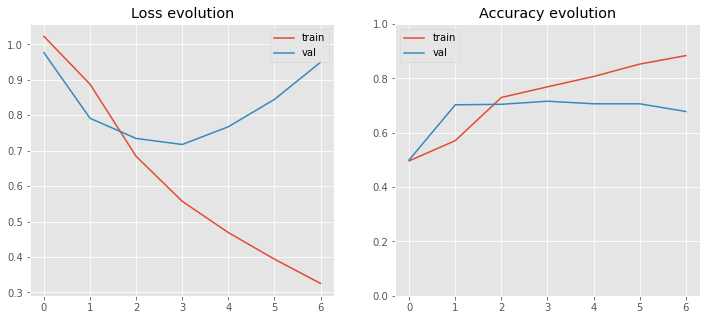

Classification report: 
 
               precision    recall  f1-score   support

           1       0.74      0.72      0.73       825
           2       0.29      0.31      0.30       377
           3       0.80      0.80      0.80      1198

    accuracy                           0.70      2400
   macro avg       0.61      0.61      0.61      2400
weighted avg       0.70      0.70      0.70      2400

The confusion matrix is: 
 
 score    1    2    3
row_0               
1      595  113   93
2      140  116  142
3       90  148  963


In [49]:
MODEL_OUTPUT_DIM = 3

CNNmodel = build_cnn_v2(MODEL_OUTPUT_DIM, wv_matrix,  input_size,
                        MAX_LENGTH, EMBEDDING_DIM, 

                        embeddings_initializer = 'uniform')
C1 = fit_and_give_scores(CNNmodel, padded_data_sequences_train, y_train_encoded,
                    padded_data_sequences_test , y_test , name = 'CNN',
                    epochs = 10)

Epoch 1/20
17/17 [==============================] - 6s 298ms/step - loss: 1.2499 - accuracy: 0.4918 - val_loss: 1.1275 - val_accuracy: 0.5000
Epoch 2/20
17/17 [==============================] - 5s 286ms/step - loss: 1.1065 - accuracy: 0.5002 - val_loss: 1.0916 - val_accuracy: 0.5000
Epoch 3/20
17/17 [==============================] - 5s 287ms/step - loss: 1.0861 - accuracy: 0.5002 - val_loss: 1.0773 - val_accuracy: 0.5000
Epoch 4/20
17/17 [==============================] - 5s 288ms/step - loss: 1.0667 - accuracy: 0.5054 - val_loss: 1.0467 - val_accuracy: 0.5303
Epoch 5/20
17/17 [==============================] - 5s 289ms/step - loss: 1.0270 - accuracy: 0.6092 - val_loss: 1.0091 - val_accuracy: 0.6288
Epoch 6/20
17/17 [==============================] - 5s 290ms/step - loss: 0.9926 - accuracy: 0.6680 - val_loss: 0.9844 - val_accuracy: 0.6780
Epoch 7/20
17/17 [==============================] - 5s 286ms/step - loss: 0.9749 - accuracy: 0.6979 - val_loss: 0.9807 - val_accuracy: 0.7017
Epoch 

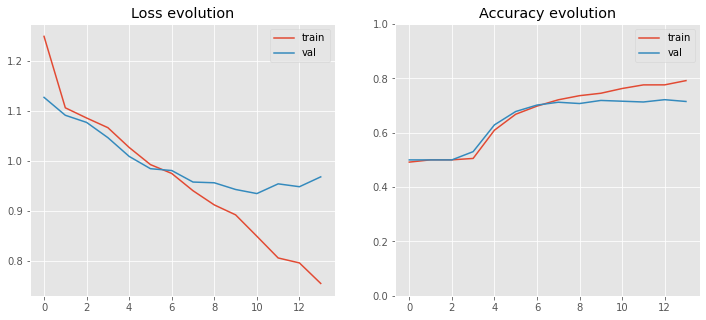

Classification report: 
 
               precision    recall  f1-score   support

           1       0.72      0.77      0.75       825
           2       0.32      0.11      0.16       377
           3       0.76      0.88      0.82      1198

    accuracy                           0.72      2400
   macro avg       0.60      0.59      0.57      2400
weighted avg       0.68      0.72      0.69      2400

The confusion matrix is: 
 
 score    1    2     3
row_0                
1      639  140   104
2       50   40    36
3      136  197  1058


In [50]:
CNNmodel2 = build_cnn_v2(MODEL_OUTPUT_DIM, wv_matrix,  input_size,
                        MAX_LENGTH, EMBEDDING_DIM, 
                        l1 = 0.001,
                        embeddings_initializer = 'uniform')
C2 = fit_and_give_scores(CNNmodel2, padded_data_sequences_train  , y_train_encoded,
                    padded_data_sequences_test , y_test , name = 'CNN + l1',
                    epochs = 20)

Epoch 1/20
17/17 [==============================] - 6s 298ms/step - loss: 1.0461 - accuracy: 0.4953 - val_loss: 1.0170 - val_accuracy: 0.5000
Epoch 2/20
17/17 [==============================] - 5s 287ms/step - loss: 0.9903 - accuracy: 0.5172 - val_loss: 0.9523 - val_accuracy: 0.6136
Epoch 3/20
17/17 [==============================] - 5s 288ms/step - loss: 0.9053 - accuracy: 0.6709 - val_loss: 0.8532 - val_accuracy: 0.6979
Epoch 4/20
17/17 [==============================] - 5s 287ms/step - loss: 0.8452 - accuracy: 0.7027 - val_loss: 0.8553 - val_accuracy: 0.7102
Epoch 5/20
17/17 [==============================] - 5s 286ms/step - loss: 0.7968 - accuracy: 0.7324 - val_loss: 0.8283 - val_accuracy: 0.7121
Epoch 6/20
17/17 [==============================] - 5s 287ms/step - loss: 0.7668 - accuracy: 0.7425 - val_loss: 0.8314 - val_accuracy: 0.6998
Epoch 7/20
17/17 [==============================] - 5s 287ms/step - loss: 0.7460 - accuracy: 0.7473 - val_loss: 0.8430 - val_accuracy: 0.7225
Epoch 

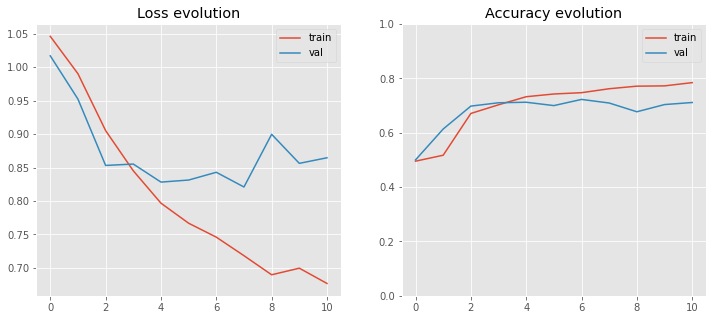

Classification report: 
 
               precision    recall  f1-score   support

           1       0.68      0.82      0.74       825
           2       0.29      0.10      0.15       377
           3       0.78      0.83      0.81      1198

    accuracy                           0.71      2400
   macro avg       0.58      0.58      0.57      2400
weighted avg       0.67      0.71      0.68      2400

The confusion matrix is: 
 
 score    1    2    3
row_0               
1      675  167  153
2       46   39   49
3      104  171  996


In [51]:
CNNmodel3 = build_cnn_v2(MODEL_OUTPUT_DIM, wv_matrix,  input_size,
                        MAX_LENGTH, EMBEDDING_DIM, 
                        l2 = 0.03,
                        embeddings_initializer = 'uniform')
C3 = fit_and_give_scores(CNNmodel3, padded_data_sequences_train  , y_train_encoded,
                    padded_data_sequences_test , y_test , name = 'CNN + l2',
                    epochs = 20)

#### Looking back

In [52]:
CNN_clean = [C1,C2,C3]

CNN_clean_dataframe = pd.concat(CNN_clean)

In [53]:
CNN_clean_dataframe

accuracy      f1  precision  recall
CNN         0.6975  0.6993     0.7014  0.6975
CNN + l1    0.7238  0.6902     0.6783  0.7238
CNN + l2    0.7125  0.6817     0.6701  0.7125

In [54]:
print(CNN_clean_dataframe.to_markdown())

|          |   accuracy |     f1 |   precision |   recall |
|:---------|-----------:|-------:|------------:|---------:|
| CNN      |     0.6975 | 0.6993 |      0.7014 |   0.6975 |
| CNN + l1 |     0.7238 | 0.6902 |      0.6783 |   0.7238 |
| CNN + l2 |     0.7125 | 0.6817 |      0.6701 |   0.7125 |
